# Cuaderno de entrenamiento de modelos clásicos
## Real Sociedad
En este cuaderno se realizarán los entrenamientos de los siguientes modelos clásicos de Machine Learning para el Trabajo de Fin de Grado:
- Naive Bayes
- Decision Trees

Autor: David Revillas
Mail: drevillas002@ikasle.ehu.eus
Fecha: 25-02-2020

# Instalación de módulos
Con la siguiente instrucción se instalan las librerías necesarias para ejecutar los scripts presentes en este Trabajo.

In [ ]:
!pip install --upgrade numpy matplotlib scikit-learn "pandas>=1.0.1" tpot graphviz xgboost

# Importación de módulos

In [1]:
import configparser
import os

import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import preprocessing
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.model_selection import  cross_val_score, cross_val_predict, cross_validate
from tpot import TPOTClassifier

import graphviz
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Save models
from joblib import dump, load

import pandas as pd
%matplotlib inline

# Configuración

Definimos la ruta al archivo de configuración y lo cargamos

In [2]:
config = configparser.ConfigParser(interpolation=configparser.BasicInterpolation())
path = '../'
config.read(os.path.join(path, 'data', 'settings.cfg'))

['../data/settings.cfg']

## Definir algunas constantes
### Clases
- 2: Corresponde a dos clases, `0` para indicar que el ganador es el local y `1` para indicar lo contrario.
- 3: Corresponde a tres clases, `0` para indicar que el ganador es el local, `1` para indicar empate y `2` 
para indicar ganador visitante.

In [24]:
num_clases = 3

### Columnas del DataFrame
Definir el nombre de las columnas

In [25]:
columnas = ["P", "L_O", "L_T", "L_MO", "L_POT", "L_ME", "L_DE", "L_P", "V_O", "V_T", "V_MO", "V_POT", "V_ME", "V_DE", "V_P", "R"]

### Equipos a analizar

- `all`: Todos los equipos de la base de datos.
- `id`: id concreto del equuipo a analizar. Por ejemplo, `92` corresponde a la Real Sociedad.

In [26]:
# fd_id_equipo = 'all'
fd_id_equipo = '92'

# Carga de datos
Cargar los datos de los partidos referentes a las temporadas 2017-2018, 2018-2019 y 2019-2020 desde los archivos `.csv`
generados previamente.

In [33]:
files = [config['PATHS']['csv_file'].format(temporada=i, fd_id_equipo=fd_id_equipo, agregacion="shin_gasparyan",
                                                num_res=num_clases) for i in ["17-18", "18-19", "19-20"]]

# Concatenar varios csv en un mismo dataframe
# https://stackoverflow.com/a/21232849
tmp = []
for t, f in enumerate(files, start=1):
    print(f"\r[*] Cargando temporada: {t}/{len(files)}", end="")
    df = pd.read_csv(f, index_col='P', header=0, names=columnas, dtype=np.float64)
    tmp.append(df)   

df = pd.concat(tmp, axis=0, ignore_index=True, names=columnas)
df.R.astype(np.int8)
print(f"\r[+] Temporadas cargadas", end="")

[+] Temporadas cargadas

In [34]:
df

L_O     L_T    L_MO   L_POT    L_ME   L_DE    L_P     V_O     V_T  \
0   1500.0  1864.0  1891.0  1844.0  2092.0  924.0  372.0  1462.0  1930.0   
1   1482.0  1857.0  1867.0  1764.0  2164.0  939.0  398.0  1457.0  1875.0   
2   1382.0  1827.0  1861.0  1883.0  2122.0  906.0  338.0  1467.0  1861.0   
3   1447.0  1934.0  1861.0  1753.0  2191.0  931.0  398.0  1549.0  2072.0   
4   1458.0  1928.0  1924.0  1790.0  2127.0  900.0  345.0  1518.0  1874.0   
..     ...     ...     ...     ...     ...    ...    ...     ...     ...   
94  1471.0  1916.0  1923.0  1860.0  2154.0  915.0  379.0  1447.0  1809.0   
95  1431.0  1925.0  1931.0  1835.0  2129.0  919.0  389.0  1458.0  1883.0   
96  1466.0  1919.0  1957.0  1822.0  2114.0  888.0  379.0  1306.0  1619.0   
97  1322.0  1751.0  1850.0  1807.0  2127.0  904.0  335.0  1403.0  1807.0   
98  1497.0  1848.0  1911.0  1907.0  2110.0  887.0  379.0  1385.0  1808.0   

      V_MO   V_POT    V_ME    V_DE    V_P    R  
0   1867.0  1774.0  2191.0   939.0  398.0  2.0  
1   1911.0  1866.0  2154.0   937.0  378.0  0.0  
2   1871.0  1806.0  2164.0   950.0  398.0  2.0  
3   2024.0  1998.0  2341.0  1028.0  418.0  2.0  
4   1784.0  1789.0  2157.0   911.0  398.0  0.0  
..     ...     ...     ...     ...    ...  ...  
94  1856.0  1840.0  2124.0   956.0  405.0  2.0  
95  1955.0  1792.0  2071.0   883.0  379.0  0.0  
96  1893.0  1783.0  1873.0   864.0  349.0  0.0  
97  1886.0  1736.0  2008.0   914.0  379.0  0.0  
98  1864.0  1889.0  2122.0   930.0  383.0  0.0  

[99 rows x 15 columns]

## Estadística descriptiva

In [35]:
df.describe()

L_O          L_T         L_MO        L_POT         L_ME  \
count    99.000000    99.000000    99.000000    99.000000    99.000000   
mean   1443.444444  1872.080808  1892.626263  1829.121212  2124.212121   
std      63.627459    81.195114    81.916157    66.821308    90.613698   
min    1279.000000  1591.000000  1733.000000  1714.000000  1898.000000   
25%    1416.000000  1826.500000  1840.000000  1780.500000  2084.500000   
50%    1447.000000  1872.000000  1868.000000  1820.000000  2122.000000   
75%    1473.500000  1916.000000  1927.500000  1861.000000  2161.500000   
max    1641.000000  2097.000000  2166.000000  1997.000000  2375.000000   

              L_DE         L_P         V_O          V_T         V_MO  \
count    99.000000   99.000000    99.00000    99.000000    99.000000   
mean    927.131313  391.020202  1442.30303  1875.121212  1883.363636   
std      35.947991   20.058577    61.92119    87.133052    73.317795   
min     852.000000  335.000000  1306.00000  1619.000000  1720.000000   
25%     904.500000  379.000000  1420.50000  1826.500000  1842.500000   
50%     927.000000  398.000000  1439.00000  1873.000000  1871.000000   
75%     949.000000  398.000000  1462.00000  1918.000000  1912.500000   
max    1029.000000  439.000000  1674.00000  2147.000000  2166.000000   

             V_POT         V_ME         V_DE         V_P          R  
count    99.000000    99.000000    99.000000   99.000000  99.000000  
mean   1823.747475  2118.919192   926.353535  391.949495   0.828283  
std      65.567747    82.835918    33.036873   20.475657   0.869440  
min    1678.000000  1873.000000   838.000000  343.000000   0.000000  
25%    1786.000000  2077.000000   906.000000  379.000000   0.000000  
50%    1810.000000  2121.000000   926.000000  398.000000   1.000000  
75%    1853.000000  2154.000000   940.500000  398.000000   2.000000  
max    1998.000000  2341.000000  1028.000000  439.000000   2.000000

### Comprobar si esta balanceada

In [36]:
df['R'].value_counts()

0.0    47
2.0    30
1.0    22
Name: R, dtype: int64

# Preprocesamiento
Comenzar separando las variables predictoras y la clase en conjuntos de entrenamiento y test.

In [37]:
X = df.loc[:, columnas[1:-1]].values
y = df[columnas[-1]].values.astype(int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (89, 14)
Test shape: (10, 14)


## TPOT

TPOT es una herramienta orientada al Machine Learning que optimiza el flujo de trabajo con programación genética. De esta manera se puede establecer *pipeline* "óptimo" que devuelva buenos resultados

In [11]:
tpot = TPOTClassifier(generations=50, population_size=50, verbosity=2, n_jobs=-1, cv=LeaveOneOut(), 
                      scoring='accuracy', early_stop=10)
tpot.fit(X_train, y_train)
# print(tpot.score(X_test, y_test))
tpot.export(f'tpot_{fd_id_equipo}_{num_clases}.py') 

Generation 1 - Current best internal CV score: 0.6179775280898876
Generation 2 - Current best internal CV score: 0.6179775280898876


TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=1.0, max_depth=7, max_features=0.2, min_samples_leaf=2, min_samples_split=17, n_estimators=100, subsample=0.45)


## Estandarización
***Feature scaling through standardization (or Z-score normalization) can be an important preprocessing step for many 
machine learning algorithms. Standardization involves rescaling the features such that they have the properties of a 
standard normal distribution with a mean of zero and a standard deviation of one.*** [Importance of Feature Scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py)

In [ ]:
# scaler = preprocessing.MinMaxScaler()
# scaler.fit(X)
# X = scaler.transform(X)

# print(X)

## Visualización del problema
### Reducción de la dimensionalidad
Mediante el [análisis de las componentes principales](https://es.wikipedia.org/wiki/An%C3%A1lisis_de_componentes_principales) 
se pueden reducir las dimensiones para poder visualizarlas en un gráfico. Puesto que esta reducción hace que se pierda 
información, hay que considerar utilizarla si no se alcanza una varianza arbitaria del 85%, por ejemplo.

Sum: 0.7464480037469565


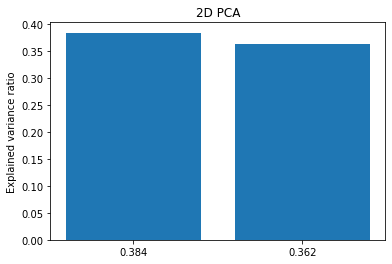

In [38]:
pca = PCA(2)
X_pca = pca.fit_transform(X)

n_componentes = [0, 1]
variance = pca.explained_variance_ratio_

plt.bar(n_componentes, variance, align='center')
plt.xticks(n_componentes, [round(i, 3) for i in variance])
plt.ylabel('Explained variance ratio')
plt.title('{0}D PCA'.format(len(n_componentes)))

print("Sum: {0}".format(sum(variance)))


### Representación en el plano
Una vez preprocesados los datos, se dibujan en el plano para comprobar si existe algún patrón que haga distinguir los 
casos. Hay que recordar que si se ha aplicado el PCA, se habrá perdido información.

Text(0, 0.5, 'Second Principal Component')

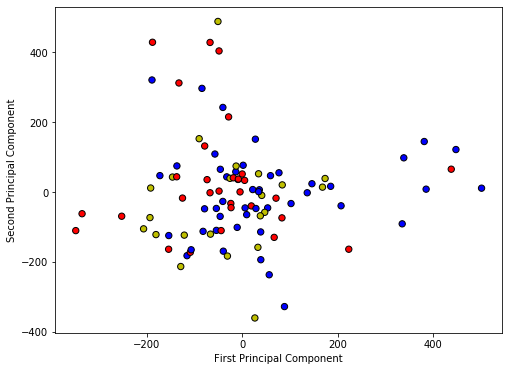

In [39]:
plt.figure(figsize=(8, 6))

# Color
col = []
for i in y:
    if i == 0:
        col.append('b')
    elif i == 1:
        col.append('y')
    elif i == 2:
        col.append('r')

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=col, edgecolors=(0, 0, 0), s=40)    
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

# Clasificadores
Crear instancias de los modelo de clasificación y entrenarlos con el conjunto de datos.



## Pipeline TPOT obtenido

In [14]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, Normalizer
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy
from sklearn.preprocessing import RobustScaler
from tpot.builtins import ZeroCount
from sklearn.feature_selection import RFE
from sklearn.linear_model import SGDClassifier

tpot_data = df.copy()
features = tpot_data.drop('R', axis=1)
training_features, testing_features, training_target, testing_target = \
    train_test_split(features, tpot_data['R'], random_state=42, test_size=0.1)

if num_clases == 2:
    # Average CV score on the training set was: 0.7458100994684268
#     exported_pipeline = make_pipeline(
#         make_union(
#             make_pipeline(
#                 Normalizer(norm="max"),
#                 MinMaxScaler()
#             ),
#             FunctionTransformer(copy)
#         ),
#         Normalizer(norm="max"),
#         ExtraTreesClassifier(bootstrap=True, criterion="entropy", max_features=0.05, min_samples_leaf=17, min_samples_split=14, n_estimators=100)
#     )
    # Average CV score on the training set was: 0.6801123595505618
    exported_pipeline = make_pipeline(
        RFE(estimator=ExtraTreesClassifier(criterion="gini", max_features=0.15000000000000002, n_estimators=100), step=0.7000000000000001),
        StackingEstimator(estimator=SGDClassifier(alpha=0.001, eta0=0.01, fit_intercept=True, l1_ratio=0.25, learning_rate="invscaling", loss="perceptron", penalty="elasticnet", power_t=50.0)),
        ExtraTreesClassifier(bootstrap=True, criterion="gini", max_features=0.45, min_samples_leaf=3, min_samples_split=17, n_estimators=100)
    )
elif num_clases == 3:
    # Average CV score on the training set was: 0.563358302122347
    exported_pipeline = make_pipeline(
        RobustScaler(),
        RobustScaler(),
        ZeroCount(),
        ZeroCount(),
        ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.35000000000000003, min_samples_leaf=7, min_samples_split=3, n_estimators=100)
    )

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

#### Guardar el modelo aprendido

In [15]:
dump(exported_pipeline, os.path.join(config['PATHS']['prod'], f'tpot_{fd_id_equipo}_{num_clases}.joblib'))

['/home/david/Git/Football-api/prod/tpot_all_2.joblib']

## [*Decision Trees*](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
Es un método fácil en el que el modelo trata de predecir la clase de una instancia utilizando reglas de aprendidas mediante la inferencia de los datos de entrenamiento.

In [40]:
tree = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=5)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

#### Guardar el modelo aprendido

In [41]:
dump(tree, os.path.join(config['PATHS']['prod'], f'tree_{fd_id_equipo}_{num_clases}.joblib'))

['/home/david/Git/Football-api/prod/tree_92_3.joblib']

## [*Naïve Bayes*](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)

In [42]:
bayes = GaussianNB()
bayes.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

#### Guardar el modelo aprendido

In [43]:
dump(bayes, os.path.join(config['PATHS']['prod'], f'bayes_{fd_id_equipo}_{num_clases}.joblib'))

['/home/david/Git/Football-api/prod/bayes_92_3.joblib']

# Evaluación

## *Cross-Validation*

Se puede realizar una [Cross Validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) que separe los 
datos en `n` subconjutos, de manera que se entrenen `n` veces los modelos, entrenando con `n-1` subconjuntos distintos 
en cada iteración y probarlo con el conjunto restante

Se pueden utilizar los métodos ya implementados de *scikit-learn*:
1. [*cross validate*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html): Returns an array of scores of the estimator for each run of the cross validation. A dict of arrays containing the score/time arrays for each scorer is returned.
2. [*cross-val-score*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html): Returns an array of scores of the estimator for each run of the cross validation. Devuelve la **exactitud** de la clasificación por cada iteración.
3. [*cross_val_predict*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html): Generate cross-validated estimates for each input data point. It is **not appropriate** to pass these predictions into an evaluation metric. Use *cross_validate* to measure generalization error.

En caso de que el conjunto de datos sea pequeño, se puede realizar una validación cruzada con tantas iteraciones como 
casos haya, técnica conocida como *Leave One Out*. Para ello, se puede pasar como parámetro `cv` el número de iteraciones 
o el iterador `LeaveOneOut()`.


### Modelo TPOT

Train accuracy: 0.65 (+/- 0.09)
              precision    recall  f1-score   support

         0.0       0.54      0.49      0.51        41
         1.0       0.67      0.71      0.69        59

    accuracy                           0.62       100
   macro avg       0.60      0.60      0.60       100
weighted avg       0.61      0.62      0.62       100



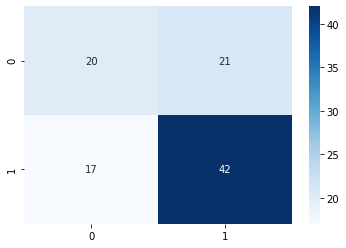

In [16]:
cv_tpot = cross_val_score(exported_pipeline, X_train, y_train, cv=LeaveOneOut())
print("Train accuracy: %0.2f (+/- %0.2f)" % (cv_tpot.mean(), cv_tpot.std() * 2))

cm_tpot = confusion_matrix(testing_target, results)
print(classification_report(testing_target, results))
sn.heatmap(cm_tpot, annot=True, fmt='g', cmap=plt.cm.Blues)

### Modelo Decision Tree

Train accuracy: 0.51 (+/- 1.00)
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         3

    accuracy                           0.60        10
   macro avg       0.25      0.33      0.29        10
weighted avg       0.45      0.60      0.51        10



/home/david/Git/Football-api/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'dt_arch_92_3.pdf'

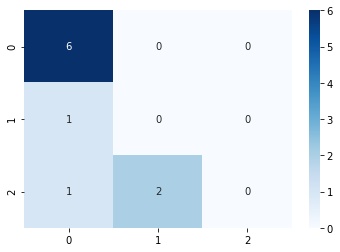

In [44]:
cv_tree = cross_val_score(tree, X_train, y_train, cv=LeaveOneOut())
print("Train accuracy: %0.2f (+/- %0.2f)" % (cv_tree.mean(), cv_tree.std() * 2))

y_pred = tree.predict(X_test)
cm_tree = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
sn.heatmap(cm_tree, annot=True, fmt='g', cmap=plt.cm.Blues)

# Entrenamos el árbol sólo para mostrarlo
dot_data = export_graphviz(tree, out_file=None, feature_names=columnas[1:-1]) 
graph = graphviz.Source(dot_data)
graph.render(f'dt_arch_{fd_id_equipo}_{num_clases}') 

### Modelo Naïve Bayes

Train accuracy: 0.36 (+/- 0.96)
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           1       0.33      1.00      0.50         1
           2       0.60      1.00      0.75         3

    accuracy                           0.60        10
   macro avg       0.64      0.78      0.58        10
weighted avg       0.81      0.60      0.57        10



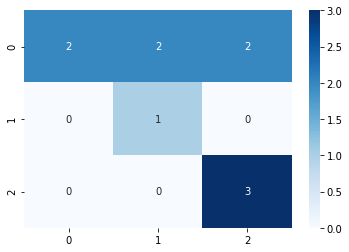

In [45]:
cv_nb = cross_val_score(bayes, X_train, y_train, cv=LeaveOneOut())
print("Train accuracy: %0.2f (+/- %0.2f)" % (cv_nb.mean(), cv_nb.std() * 2))

y_pred = bayes.predict(X_test)
cm_nb = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
sn.heatmap(cm_nb, annot=True, fmt='g', cmap=plt.cm.Blues)

## Curva ROC

In [ ]:
from sklearn.metrics import plot_roc_curve
ax = plt.gca()

tpot_disp = plot_roc_curve(exported_pipeline, X_test, y_test)
tree_disp = plot_roc_curve(bayes, X_test, y_test, ax=ax, alpha=.8)
tree_disp.plot(ax=ax, alpha=.8)
plt.show()